# TP2: MACHINE LEARNING APPLICATION

Following the previous nootbook, in this notebook, you will learn the general fundamental of machine learning applied to a classification task which is LGG vs GBM (binary classification). Of course, the aim is not to find the best pipeline with the best algorithm for this task but to understand the principle concept. First, download necessary materials for the afternoon practical sessions.

In [11]:
!git clone https://github.com/marsvn/PythonM2-jour3.git
%cd PythonM2-jour3/

Cloning into 'PythonM2-jour3'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 160 (delta 0), reused 0 (delta 0), pack-reused 157 (from 1)
Receiving objects: 100% (160/160), 163.26 MiB | 34.70 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (132/132), done.
/content/PythonM2-jour3/PythonM2-jour3


### Installation of python dependencies

In [12]:
!pip install scikit-learn pandas matplotlib numpy


## General Machine Learning Steps

Before we start, let's review the general machine learning steps:

1. Data collection, preprocessing (e.g., integration, cleaning, etc.), and exploration;
   - Split a dataset into the **training** and **testing** datasets
2. Model development:  
    A. Assume a model $\{f\}$ that is a collection of candidate functions $f$’s (representing posteriori knowledge) we want to discover. Let's assume that each $f$ is parametrized by ${w}$  
    B.Define a **cost function** $C({w})$ that measures "how good a particular $f$ can explain the training data." The lower the cost function the better;  
3. **Training:** employ an algorithm that finds the best (or good enough) function $f^{*}$ in the model that minimizes the cost function over the training dataset
4. **Testing**: evaluate the performance of the learned $f^{*}$ using the testing dataset;
5. Apply the model in the real world.

## Load data

In [13]:
import pandas as pd
from IPython.display import display

path_dataset = './data/radiomics_analysis_cleaned.csv'

data = pd.read_csv(path_dataset)
# we will only work with the full area segmentation with all sequences
data = data[data['segmentation']=='full']

data = data.pivot_table(index=['patient', 'label'],
                                columns=['sequence', 'segmentation'],
                                values=data.columns[4:])
data.columns = ['_'.join(col).strip() for col in data.columns.values]
data.reset_index(level=1, inplace=True)

display(data)

# Convert LGG into class 0 and HGG into class 1
data.loc[data['label'] == 'HGG', 'label'] = 1
data.loc[data['label'] == 'LGG', 'label'] = 0

,label,original_firstorder_10Percentile_flair_full,original_firstorder_10Percentile_t1_full,original_firstorder_10Percentile_t1ce_full,original_firstorder_10Percentile_t2_full,original_firstorder_90Percentile_flair_full,original_firstorder_90Percentile_t1_full,original_firstorder_90Percentile_t1ce_full,original_firstorder_90Percentile_t2_full,original_firstorder_Energy_flair_full,...,original_shape_SurfaceArea_t1ce_full,original_shape_SurfaceArea_t2_full,original_shape_SurfaceVolumeRatio_flair_full,original_shape_SurfaceVolumeRatio_t1_full,original_shape_SurfaceVolumeRatio_t1ce_full,original_shape_SurfaceVolumeRatio_t2_full,original_shape_VoxelVolume_flair_full,original_shape_VoxelVolume_t1_full,original_shape_VoxelVolume_t1ce_full,original_shape_VoxelVolume_t2_full
patient,,,,,,,,,,,,,,,,,,,,,
TCGA-02-0003,HGG,144.118668,-37.915257,3.103941,46.780552,373.385712,95.536186,288.818451,216.258804,2.470281e+10,...,18552.213339,18552.213339,0.235856,0.235856,0.235856,0.235856,78933.0,78933.0,78933.0,78933.0
TCGA-02-0006,HGG,116.257912,-89.206642,-94.285591,-24.314096,423.313324,44.255459,37.271446,128.743958,1.147067e+10,...,14069.926539,14069.926539,0.370668,0.370668,0.370668,0.370668,38314.0,38314.0,38314.0,38314.0
TCGA-02-0009,HGG,90.176323,-26.945517,-8.762620,-32.354511,225.455673,113.102806,152.701782,71.986130,5.131474e+09,...,8589.699469,8589.699469,0.352593,0.352593,0.352593,0.352593,24434.0,24434.0,24434.0,24434.0
TCGA-02-0011,HGG,64.619064,-72.600388,-51.918762,4.858555,361.840515,110.048798,177.660934,303.965820,3.725537e+10,...,23198.153661,23198.153661,0.181913,0.181913,0.181913,0.181913,127812.0,127812.0,127812.0,127812.0
TCGA-02-0027,HGG,86.231560,-21.451303,-61.386211,0.316952,318.213013,142.173523,210.579803,311.565369,1.366329e+10,...,11398.987373,11398.987373,0.212541,0.212541,0.212541,0.212541,53787.0,53787.0,53787.0,53787.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TCGA-HT-8114,LGG,105.555672,-63.724358,-142.988251,5.321779,303.597015,112.424210,39.730719,230.225479,5.211240e+10,...,21896.327956,21896.327956,0.116140,0.116140,0.116140,0.116140,188686.0,188686.0,188686.0,188686.0
TCGA-HT-8563,LGG,107.853134,-13.839657,-107.915237,41.547455,343.804901,81.128136,50.434380,214.858383,4.311416e+10,...,21457.413791,21457.413791,0.141783,0.141783,0.141783,0.141783,151508.0,151508.0,151508.0,151508.0
TCGA-HT-A5RC,LGG,132.378906,-53.662895,-43.392906,-14.490097,300.511658,75.641731,214.946136,117.851212,1.783356e+10,...,19835.667125,19835.667125,0.304579,0.304579,0.304579,0.304579,65454.0,65454.0,65454.0,65454.0


## Splitting datas

Let’s now use <code>train_test_split</code> from the function in scikit-learn to divide features data (x_data) and target data (y_data) even further into train and test. Here we will have 30% of the data for the test set. It is also a good practice to define a random state for reproducible results.

Note: Stratify parameter in the function makes the equal proportion in the split. For example, if variable y is a binary categorical variable with values 0 and 1 and there are 25% of zeros and 75% of ones, stratify=y_data will make sure that your random split has 25% of 0's and 75% of 1'

In [14]:
x_data, y_data = data.drop(columns='label'), data['label'].astype(int).to_numpy()

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data ,test_size = 0.3, random_state=123, stratify=y_data)
print('x_train shape: ', x_train.shape)
print('x_test shape: ', x_test.shape)
print('y_train shape: ', y_train.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (170, 400)
x_test shape:  (73, 400)
y_train shape:  (170,)
y_test shape:  (73,)


Now we have our training set wich is a set for training (and validation). The test set is considered like an unseen set and **will be never seen until the model performance evaluation** – this has to be data that your model hasn’t seen before.

But the strategy for evaluate a model depends on your goal and approach.

 - **Scenario 1: Just train a simple model**  
Split the dataset into a separate training and testing set. Train the model on the former, evaluate the model on the latter. Evaluation is done by different performance metrics such as the error, precision, recall, ROC auc, etc.)
 - **Scenario 2: Train a model and tune (optimize) its hyperparameters.**  
Split the dataset into a separate training and validation set. Use techniques such as k-fold cross-validation on the training set to find the “optimal” set of hyperparameters for the model. After the hyperparameter tuning, use the independent test set to get an unbiased estimate of its performance.
 - **Scenario 3: Build different models and compare algorithms (e.g., SVM vs. logistic regression vs. Random Forests, etc.).**  
We use nested or double cross-validation. In nested cross-validation, we have another k-fold cross-validation loop to split the data into training and validation folds. After model selection, the test fold is then used to evaluate the model performance. After the model selection, the testing dataset which was specified above is applied to evaluate our favorite model.

<a href="https://sebastianraschka.com/faq/docs/evaluate-a-model.html">
  <img src="https://github.com/marsvn/PythonM2-jour3/blob/main/images/evaluate_overview.png?raw=1" alt="evaluate_overview" class="center">
</a>

# 1) Introduction to data preprocessing

Data pre-processing is an integral step in machine learning because the quality of the data and the useful information that can be derived from it directly affects the ability of our model to learn, so it is extremely important that we pre-process our data before introducing it into our model.

### Handling Null Values

In any real world dataset there are always few null values. Very few models can handle these NULL or NaN values on its own so we need to intervene. In python NULL is represented with NaN. First of all, we need to check whether we have null values in our dataset or not. We can do that using the isnull() method.

In [16]:
data.isnull().sum() # add .any() if you want to know about if there is any NaN in the sum (returns bool)
# Returns the column names along with the number of NaN values in that particular column (we can specify the axis=1, if we want rows)

,0
label,0
original_firstorder_10Percentile_flair_full,0
original_firstorder_10Percentile_t1_full,0
original_firstorder_10Percentile_t1ce_full,0
original_firstorder_10Percentile_t2_full,0
...,...
original_shape_SurfaceVolumeRatio_t2_full,0
original_shape_VoxelVolume_flair_full,0
original_shape_VoxelVolume_t1_full,0
original_shape_VoxelVolume_t1ce_full,0


We don't have any NaN for our datas. But there is some strategy to handle the missing datas

#### 1. The easiest way to solve the problem of NaN is by dropping the rows or columns that contain null values.

In [17]:
data.dropna(); # (axis=0 for columns or 1 for rows), you have various parameters for dropna(), like 'how', 'tresh',
# take a look at https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.dropna.html

#### 2. Imputation

Imputation is simply the process of substituting the missing values of our dataset. So we can change replace the values by the mean, max, 0, custom function ... Train another algorithm to predict the missing value from the rest of the data

In [18]:
data.fillna(0); # will replace NaN values by a 0, take a look at https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html

<ipython-input-18-57eac4c5cf8a>:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna(0); # will replace NaN values by a 0, take a look at https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.fillna.html


### Standardization/Normalization

Different radiomics features have different units and range. Some features were designed to fall between 0 and 1, while others have a very large range. In some machine learning algorithms, the objective functions will not work properly without normalization. For example, many classifiers calculate the distance between two points by the Euclidean distance. If one of the features has a wide range of values, the distance will be governed by that particular characteristic. Therefore, the range of all characteristics should be normalized so that each characteristic contributes approximately proportionally to the final distance. We will present the two most common techniques which are used.

#### 1. Min-Max scaling

This estimator scales and translates each feature individually such that it is in the given range on the training set, e.g. between zero and one.

$$ X_{norm} = \frac{X - X_{min}}{X_{max}-X_{min}} $$

Scikit-learn directly implements this for us:

In [19]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(x_train)
x_train_standardize = scaler.transform(x_train)
# We apply the same transform on the test
x_test_standardize = scaler.transform(x_test)

#### 2. Z-Score normalization

It standardize features by removing the mean and scaling to unit variance. By anothers words, we transform our values such that the mean of the values is 0 and the standard deviation is 1.

$$ Z = \frac{x_i - \mu}{\sigma} $$  
with mean: $$ \mu = \frac{1}{N} \sum_{i=1}^N (x_i) $$
and standard deviation: $$ \sigma = \sqrt{\frac{1}{N} \sum_{i=1}^N (x_i - \mu)^2} $$

**Exercice:**
Complete the following scripts to:

- do the Z-Score normalization on the <code>x_train</code> and apply it on the  <code>x_test</code> without using the scikit-learn function.

In [20]:
#@title Solution 1

# z-score function

import numpy as np
import operator
import pandas as pd


def z_score(X):
    # zero mean and unit variance
    mean = np.mean(X, axis=0)
    std_dev = np.std(X, axis=0)
    z = (X - np.mean(X, axis=0)) / np.std(X, axis=0)
    return z, mean, std_dev


x_train_standardize, mean, std_dev = z_score(x_train)
x_test_standardize = ((x_test - mean) / std_dev)
# Yes, on the test set, you need to apply the value find in the train set!


In [21]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_train)
x_train_standardize = scaler.transform(x_train)
# We apply the same transform on the test
x_test_standardize = scaler.transform(x_test)

There are many other techniques, you can consult this link which
 <a href="https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html#sphx-glr-auto-examples-preprocessing-plot-all-scaling-py">compares the effect of different scalers on data with outliers</a>

# 2) Building models

#### Standard validation (Hold-Out method)

Previously we have separated our train and test set datas. The entire train data has been used so far to derive estimates of means and variances for each feature such as to perform Z-score normalization.

We now further split the training set into a smaller training set and a validation set. The training set samples will all be used to optimize the parameters of a model (i.e. iteratively converge to a satisfying model from the input family of functions), and the validation set will be used to select a good set of hyper-parameters such as the family of functions to optimize (here, logestic regression, decision trees, support vector machines).

The function `train_test_split()` from scikit-learn  is also used on the pair (features, labels) of the training set:

<a href="https://arxiv.org/pdf/1811.12808.pdf">
  <img src="https://github.com/marsvn/PythonM2-jour3/blob/main/images/holdout_method.png?raw=1" alt="holdout_method" class="center"  height="500" width="500" >
</a>

In [22]:
train_features, validation_features, train_labels, validation_labels = \
  train_test_split(x_train, y_train ,test_size = 0.3, random_state=123, stratify=y_train)

print('train_features shape: ', train_features.shape)
print('validation_features shape: ', validation_features.shape)
print('train_labels shape: ', train_labels.shape)
print('validation_labels shape: ', validation_labels.shape)

train_features shape:  (119, 400)
validation_features shape:  (51, 400)
train_labels shape:  (119,)
validation_labels shape:  (51,)


#### Examples of model building with scikit-learn

Of the reasons scikit-learn is the leading data science library worldwide is its simplicity of usage and its consistency. By design, the library implements a wide range of machine learning and data processing algorithms, including the most used machine learning families of functions such as logistic regression or boosting algorithms. Here, we will see some examples of machine learning algorithms, including the standard training pipelines using sklearn.

As one of the popular classifiers in the medical field applications, logistic regression models the relationship between a categorical response variable $y$ and a set
of $x \in R^k$ of $k$ features per input by fitting a linear equation. The aim is to specify the weights or coefficients in the linear function such that the output be close to the real label.

While all of the training process of logistic regression can be coded by hand, its implementation in sklearn lies in the two lines as follows:

In [23]:
from sklearn.linear_model import LogisticRegression
logistic_regression_model = LogisticRegression()  # instantiate a logistic regression model with default parameters
print(logistic_regression_model)

LogisticRegression()


Training is then performed using the `fit` function, which applies gradient descent with input hyper-parameters, and usually stops once a training hyper-parameter is satisfied, such as minimal training error tolerance or number of iterations:

In [24]:
clf = logistic_regression_model.fit(X=train_features, y=train_labels)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


##### Performance assessment

Once the model is trained, i.e. `fit` function is done, it can be used to classify any input sample with the correct shape, or vectors of 140 features in this case. Notably, training and validation accuracies can be obtained with other performance indicators:

In [25]:
accuracy_train = clf.score(X=train_features, y=train_labels)
probs = clf.predict_proba(train_features)
accuracy_validation = clf.score(X=validation_features, y=validation_labels)
print('Training accuracy', accuracy_train, '; Validation accuracy', accuracy_validation)

Training accuracy 0.8991596638655462 ; Validation accuracy 0.7843137254901961


In this case, the dataset contain more positive samples than negative samples, which imply that a model outputting only the positive class, resulting in an accuracy higher than 50%. In other words, the accuracy may not always be suited to the needs of the task in hand. Other performance metrics, such as balanced accuracy (https://en.wikipedia.org/wiki/Precision_and_recall), are implemented in scikit-learn (https://scikit-learn.org/stable/modules/model_evaluation.html). All implemented performance metrics take two vectors as their inputs, one for the predictions of any model and one for ground-truths. We first need to explicitely compute probabilities of the trained model and then run sklearn metrics functions:


In [26]:
# Use the trained model (clf) to explicitely compute probabilities of all training and validation samples
predicted_training_probabilities = clf.predict_proba(train_features)[:, 1]  # for each sample, two outputs probas summing to 1: one for class 0 (LGG), the other for class 1 (HGG)
predicted_validation_probabilities = clf.predict_proba(validation_features)[:, 1]  # for each sample, two outputs probas summing to 1: one for class 0 (LGG), the other for class 1 (HGG)

# Compute predicted classes from predicte?d probabilities by thresholded probabilities with 0.5: a probability higher than 0.5 would yield HGG prediction, otherwise LGG prediction
training_predicted_classes = list(map(lambda proba: int(proba > .5), predicted_training_probabilities))
validation_predicted_classes = list(map(lambda proba: int(proba > .5), predicted_validation_probabilities))

from sklearn.metrics import balanced_accuracy_score, roc_auc_score

# Metrics function expect first the ground-truth vector, then the predicted probabilities/classes one
training_balanced_accuracy = balanced_accuracy_score(train_labels, training_predicted_classes)
validation_balanced_accuracy = balanced_accuracy_score(validation_labels, validation_predicted_classes)
print('Training balanced accuracy', training_balanced_accuracy, '; Validation balanced accuracy', validation_balanced_accuracy)

training_auc = roc_auc_score(train_labels, predicted_training_probabilities)
validation_auc = roc_auc_score(validation_labels, predicted_validation_probabilities)
print('Training AUC', training_balanced_accuracy, '; Validation AUC', validation_balanced_accuracy)


Training balanced accuracy 0.8960834762721555 ; Validation balanced accuracy 0.78027950310559
Training AUC 0.8960834762721555 ; Validation AUC 0.78027950310559


Although the balanced accuracy alleviate the issue of class imbalance, it is not a rigourous performance assessment of a decision system. Any decision system performance should be assessed using two measures, such as precision and recall. While giant technology companies can make mistakes in online tools such as Facebook suggesting friends tagging on newly uploaded pictures, in medical routine tasks, errors can have a significant impact on patient care or material maintenance. For instance, errors that a patient may be suffering from cancer (false positive) have less impact than false negative that do not detect patients with cancer. The community would expect guarantees that the level of false negative is close to none for most diagnostic tasks, even if the amount of false positive is significant.

**Exercice:**
Complete the following script to:

- evaluate the logistic regression model trained above, using sklearn documentation (https://scikit-learn.org/stable/modules/model_evaluation.html)
- more specifically, compute the precision (also called positive predictive value) and recall (also called true positive rate or sensitivity) called  of the trained classifier on both training and testing sets.

In [27]:
#@title Solution 2

from sklearn.metrics import precision_score, recall_score

training_precision = precision_score(train_labels, training_predicted_classes)
training_recall = recall_score(train_labels, training_predicted_classes)

validation_precision = precision_score(validation_labels, validation_predicted_classes)
validation_recall = recall_score(validation_labels, validation_predicted_classes)

print('Training precision', training_precision, '; training recall', training_recall)
print('Validation precision', validation_precision, '; Validation recall', validation_recall)

#Note: pays attention that the two metrics functions take predicted classes as input)

Training precision 0.8970588235294118 ; training recall 0.9242424242424242
Validation precision 0.7931034482758621 ; Validation recall 0.8214285714285714


##### Analysing the trained model

Fundamentally, logistic regression is parametrized by one parameter per input feature called weight or coefficient plus one parameter, called bias or intercept. The parameters with higher weight have more impact on the output of the system than the ones close to 0.

Generally, the parameters of any classifier in scikit-learn can be obtained with:

In [28]:
# one parameter per input feature + one for intercept with 0
logistic_regression_parameters = clf.coef_
logistic_regression_intercept = clf.intercept_

Here, we pair each parameter with its associated feature name, then we sort the parameters by magnitude, and retrieve the top 10 with most important magnitude i.e. most important features:

In [29]:
# Pair each parameter with its associated feature name
logistic_regression_parameters_with_names = list(zip(logistic_regression_parameters[0], x_data.columns.values))
print('Example of paires param/feature name', logistic_regression_parameters_with_names[:3])
print('Intercept value', logistic_regression_intercept)

# Sort paired data with respect to absolute value of parameters
logistic_regression_parameters_with_names = sorted(logistic_regression_parameters_with_names, key=lambda pair: abs(pair[0]))

print('\nMost important features:')
# Select top 10 max magnitude parameters and print associated feature name
for parameter_value, feature_name in logistic_regression_parameters_with_names[:-10:-1]:
  print('\t\t', feature_name, 'with value:', str(parameter_value))

Example of paires param/feature name [(-6.989977569337564e-10, 'original_firstorder_10Percentile_flair_full'), (1.7656312681831942e-08, 'original_firstorder_10Percentile_t1_full'), (1.4913618221144485e-08, 'original_firstorder_10Percentile_t1ce_full')]
Intercept value [-1.3213133e-10]

Most important features:
		 original_glcm_ClusterProminence_t1ce_full with value: 1.3549480650181448e-05
		 original_glszm_LargeAreaHighGrayLevelEmphasis_t2_full with value: -1.0354423183312876e-05
		 original_glszm_LargeAreaHighGrayLevelEmphasis_t1ce_full with value: -8.797766095290376e-06
		 original_glszm_LargeAreaHighGrayLevelEmphasis_t1_full with value: 7.913814154111308e-06
		 original_glcm_ClusterProminence_flair_full with value: 3.81153088741651e-06
		 original_glrlm_RunLengthNonUniformity_flair_full with value: -3.6115832601300015e-06
		 original_glrlm_RunLengthNonUniformity_t1_full with value: -2.23117872530521e-06
		 original_glcm_ClusterProminence_t1_full with value: -1.9874112574397633e-06
	

At this point, we have trained a logistic regression model, have looked at some metrics for assessing performance, and looked into the trained parameters to infer the most important features found by the model.

Usually, we would want to further boost the performance of our decision system. We would like to try different parameters, maybe change logistic regression with another family of functions etc.

### Improving performance with hyper-parameters optimization
We saw in the previous section how to implement a logistic regression using scikit-learn for the classification of MRI images into LGG or HGG classes. However, there is no guarantee that the family of functions of logistic regression is the best suited for this task with this type of data. There are a plenty set of families of machine learning decision systems behaving and performing differently given experiment contexts. Therefore, we will look at other families of decision systems on top of logistic regression.
More specifically, we will train 6 algorithms on the training set and use the reported generalization performance on the validation set to extract the best performing family of models. We will also look into another hyper-parameter which is the standardization of the data, and compare the validation generalization performance of models trained with standardization with respect to those trained without to determine whether to apply standardization to the input data.

#### Standard validation (Hold-Out method)

We observed that how it worked above!

##### Standardization

In [30]:
# Import librairies
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


def standardize(x_train, x_test, type='zscore'):
    if type == 'zscore':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train_standardize = scaler.transform(x_train)
    # We apply the same transform on the test
    x_test_standardize = scaler.transform(x_test)
    return x_train_standardize, x_test_standardize


random_state = 1234

# We load 6 different algorithms with associated algorithm name
models = []
models.append(('Logistic Regression', LogisticRegression(random_state=random_state)))
models.append(('Linear Discriminant Analysis', LinearDiscriminantAnalysis()))
models.append(('K-nearest neighbours', KNeighborsClassifier()))
models.append(('Decision Tree Classifier', DecisionTreeClassifier(random_state=random_state)))
models.append(('Gaussian Naive Bayes', GaussianNB()))
models.append(('Support Vector Classifier', SVC(random_state=random_state)))


# We will perform the same process for each of the 6 algotithms: train on training set (fit) then get score on validation set
results_with_std = []
for model_name, model in models:
  # Apply standardization
    train_features_standardize, validation_features_standardize = standardize(x_train=train_features, x_test=validation_features, type='zscore')
    # Train model; N.B.: training features not standardized were train_features
    clf = model.fit(X=train_features_standardize, y=train_labels)
    accuracy_train = clf.score(X=train_features_standardize, y=train_labels)  # get train performance
    accuracy_val = clf.score(X=validation_features_standardize, y=validation_labels) # get validation performance
    results_with_std.append(accuracy_val)
    print("%s: train = %.3f, validation = %.3f" % (model_name, accuracy_train, accuracy_val))

Logistic Regression: train = 1.000, validation = 0.843
Linear Discriminant Analysis: train = 1.000, validation = 0.745
K-nearest neighbours: train = 0.891, validation = 0.725
Decision Tree Classifier: train = 1.000, validation = 0.745
Gaussian Naive Bayes: train = 0.874, validation = 0.863
Support Vector Classifier: train = 0.983, validation = 0.843


Generally, in machine learning, we cannot say which classifier is the best until the implementation is done.

Here, models have only been tested one time on the validation set. For more robustness let's try a cross validation !

#### K-fold cross validation

Regarding the split of data, we have done so far
- split our entire dataset into a "global machine learning optimization" set and a testing set.
- split the "global machine learning optimization" set into a training set, used to optimize the parameters of decision systems, and a validation set for hyper-parameters tuning.

This second split could have been done randomly and there is no reason to privilege some data samples over others. We could take the "global machine learning optimization" set and partition it into a new training set and new associated validation.

Cross-validation is the process of simultaneously splitting a set into two sets multiple times, where for each split one set is used to train a model whose performance is computed on the other set. This should yield more robust estimators of performance without relying on more data.

**Exercice:** Complete the script bellow to:
- implement the K-fold cross validation based on https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html
- K-fold cross validation is performed as follows:
  - Randomly split your entire dataset into k”folds”
  - For each k-fold in your dataset, build your model on k – 1 folds of the dataset. Then, test the model to check the effectiveness for kth fold
  - Save the error you see on each of the predictions
  - Repeat this until each of the k-folds has served as the test set
  - The average of your k recorded errors is called the cross-validation error and will serve as your performance metric for the model

Now, one of the most commonly asked questions is, “How to choose the right value of k?”.

Always remember, a lower value of k is more biased, and hence undesirable. On the other hand, a higher value of K is less biased, but can suffer from large variability.

A smaller value of k always takes us towards validation set approach, whereas a higher value of k leads to LOOCV approach.

Precisely, LOOCV is equivalent to n-fold cross validation where n is the number of training examples.

<a href="https://arxiv.org/pdf/1811.12808.pdf">
  <img src="https://github.com/marsvn/PythonM2-jour3/blob/main/images/cross_validation_method.png?raw=1" alt="cross_validation_method" class="center"  height="500" width="500" >
</a>

In [31]:
#@title Solution 3

from sklearn.model_selection import KFold
import numpy as np
import pandas as pd


def cross_validation(X, y, model, num_folds=5):
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.DataFrame):
        y = y.to_numpy()

    cv = KFold(n_splits=num_folds, random_state=123, shuffle=True)
    results_train, results_test = [], []
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]
        clf = model.fit(X_train, y_train)
        accuracy_train = clf.score(X=X_train, y=y_train)
        accuracy_test = clf.score(X=X_test, y=y_test)  # Return the mean accuracy
        results_train.append(accuracy_train)
        results_test.append(accuracy_test)
    return results_train, results_test


We apply a cross validation using the <code>x_train</code> data

In [32]:
from sklearn.model_selection import KFold
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


def standardize(x_train, x_test, type='zscore'):
    if type == 'zscore':
        scaler = StandardScaler()
    else:
        scaler = MinMaxScaler()
    scaler.fit(x_train)
    x_train_standardize = scaler.transform(x_train)
    # We apply the same transform on the test
    x_test_standardize = scaler.transform(x_test)
    return x_train_standardize, x_test_standardize


def cross_validation_with_standadization(X, y, model, num_folds=5):
    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()
    if isinstance(y, pd.DataFrame):
        y = y.to_numpy()

    cv = KFold(n_splits=num_folds, random_state=123, shuffle=True)
    results_train, results_test = [], []
    for train_index, test_index in cv.split(X):
        X_train, X_test, y_train, y_test = X[train_index], X[test_index], y[train_index], y[test_index]

         # standardize with z-score
        X_train, X_test = standardize(x_train=X_train, x_test=X_test, type='zscore')

        clf = model.fit(X_train, y_train)
        accuracy_train = clf.score(X=X_train, y=y_train)
        accuracy_test = clf.score(X=X_test, y=y_test)  # Return the mean accuracy
        results_train.append(accuracy_train)
        results_test.append(accuracy_test)
    return results_train, results_test

In [33]:
all_results_cv_train_w_std, all_results_cv_val_w_std, names = [], [], []
for name, model in models:
    names.append(name)
    results_cv_train_w_std, results_cv_val_w_std = cross_validation_with_standadization(X=x_train, y=y_train, model=model, num_folds=5)
    all_results_cv_train_w_std.append(results_cv_train_w_std)
    all_results_cv_val_w_std.append(results_cv_val_w_std)
    means_train, stds_train = np.mean(results_cv_train_w_std), np.std(results_cv_train_w_std)
    means_val, stds_val = np.mean(results_cv_val_w_std), np.std(results_cv_val_w_std)
    msg = "%s: train = %.3f (+/- %.3f), test = %.3f (+/- %.3f)" % (name, means_train, stds_train, means_val, stds_val)
    print(msg)

Logistic Regression: train = 1.000 (+/- 0.000), test = 0.847 (+/- 0.068)
Linear Discriminant Analysis: train = 1.000 (+/- 0.000), test = 0.800 (+/- 0.039)
K-nearest neighbours: train = 0.901 (+/- 0.019), test = 0.841 (+/- 0.069)
Decision Tree Classifier: train = 1.000 (+/- 0.000), test = 0.794 (+/- 0.053)
Gaussian Naive Bayes: train = 0.876 (+/- 0.018), test = 0.847 (+/- 0.034)
Support Vector Classifier: train = 0.976 (+/- 0.006), test = 0.829 (+/- 0.060)


Compare the results of cross validation W/O standardization:

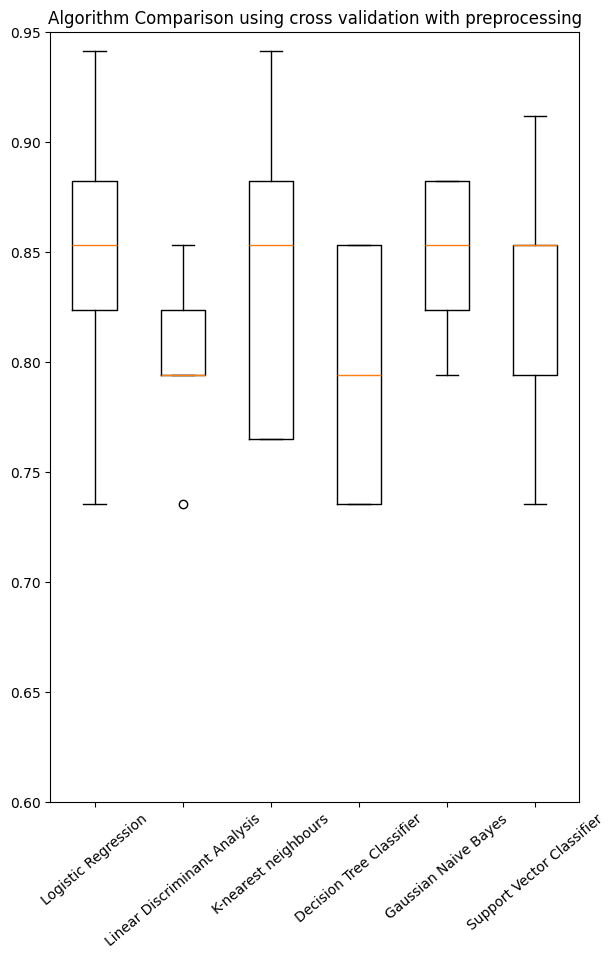

In [34]:
import matplotlib.pyplot as plt

# boxplot algorithm comparison
plt.figure(figsize=(15,10))

ax = plt.subplot(122)
plt.title('Algorithm Comparison using cross validation with preprocessing')
plt.boxplot(all_results_cv_val_w_std)
ax.set_ylim([0.60, 0.95])
ax.set_xticklabels(names, rotation=40)
plt.show();

# 3) Overfitting and Underfitting

- **Overfitting**:  
A model suffers from Overfitting when it has learned too much from the training data, and does not perform well in practice as a result. This is usually caused by the model having too much exposure to the training data.

- **Underfitting**:  
A model suffers from Underfitting when it has not learned enough from the training data, and does not perform well in practice as a result. As a direct contrast to the previous idea, this issue is caused by not letting the model learn enough from training data.

<a href="https://arxiv.org/pdf/1811.12808.pdf">
  <img src="https://github.com/marsvn/PythonM2-jour3/blob/main/images/over_and_under_fitting.png?raw=1" alt="over_under_fitting" class="center"  height="400" width="1000" >
</a>

*How to detect overfitting?*  
A key challenge with overfitting, and with machine learning in general, is that we **do not know how well our model will perform on new data until we actually test it.**

To address this, we can split our initial dataset into separate training and test subsets. This method can approximate of how well our model will perform on new data. If our model does much better on the training set than on the test set, then we’re likely overfitting.
For example, it would be a big red flag if our model saw 99% accuracy on the training set but only 55% accuracy on the test set.

*How to prevent overfitting?*  
- **Cross-validation**  
The idea is clever: Use your initial training data to generate multiple mini train-test splits. Use these splits to tune your model.
In standard k-fold cross-validation, we partition the data into k subsets, called folds. Then, we iteratively train the algorithm on k-1 folds while using the remaining fold as the test set (called the “holdout fold”). Cross-validation allows you to tune hyperparameters with only your original training set. This allows you to keep your test set as a truly unseen dataset for selecting your final model.
- **Train with more data**  
It will not work every time, but training with more data can help algorithms detect the signal better. Of course, that is not always the case. If we just add more noisy data, this technique won’t help. That is why you should always ensure your data is clean and relevant.
- **Remove features**  
Some algorithms have built-in feature selection. For those that do not, you can manually improve their generalizability by removing irrelevant input features.
- **Regularization**  
Regularization refers to a broad range of techniques for artificially forcing your model to be simpler. The method will depend on the type of learner you are using. For example, you could prune a decision tree, use dropout on a neural network, or add a penalty parameter to the cost function in regression.
- **Also, Ensembling, early stopping ...**

# 4) Hyperparameters optimization

Wikipedia states that "hyperparameter tuning/optimizization is choosing a set of optimal hyperparameters for a learning algorithm".
So what is a hyperparameter?
<div align="center">
    <i> a hyperparameter is a parameter whose value is set before the learning process begins </i>
</div>

Some examples of hyperparameters include penalty in logistic regression
In sklearn, hyperparameters are passed as arguments of the constructor of the models classes.
   
**Tuning Strategies:**
 - Grid Search  
 Also known as an exhaustive search, Grid search looks through each combination of hyperparameters. This means that every combination of specified hyperparameter values will be tried.
 - Random Search  
 As its names suggests, Random Search uses random combinations of hyperparameters. This means that not all of the parameter values are tried, and instead, parameters will be sampled with fixed numbers of iterations.

<a href="http://www.jmlr.org/papers/volume13/bergstra12a/bergstra12a.pdf">
  <img src="https://github.com/marsvn/PythonM2-jour3/blob/main/images/random_grid_search.png?raw=1" alt="random_grid_search class="center"  height="400" width="700" >
</a>

### Grid Search

We define a space for the Grid Search, we will work with z-score preprocessing in the pipeline

In [38]:
"""
Create a dictionary with classifier name as a key and it's hyper parameters options as a value for grid search
"""

import numpy as np

# Logistic Regression Params
C = [x for x in np.arange(0.1, 3, 0.2)]
penalty = ["l1", "l2"]
fit_intercept = [True, False]
solver = ["saga"]
lr_params = {'C': C,
             'penalty': penalty,
             'fit_intercept': fit_intercept,
             'solver': solver
             }

# DecisionTreeClassifier PARAMS
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
class_weight = [None, "balanced"]
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
max_features = [None, "sqrt", "log2"]
dtc_params = {'criterion': criterion,
              'splitter': splitter,
              'class_weight': class_weight,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features
              }

# KNN PARAMS
n_neighbors = [int(x) for x in np.linspace(start=1, stop=20, num=2)]
weights = ["uniform", "distance"]
algorithm = ["auto", "ball_tree", "kd_tree", "brute"]
leaf_size = [int(x) for x in np.linspace(start=5, stop=50, num=2)]
p = [int(x) for x in np.linspace(start=1, stop=4, num=1)]
knn_params = {'n_neighbors': n_neighbors,
              'weights': weights,
              'algorithm': algorithm,
              'leaf_size': leaf_size,
              'p': p,
              }

# LDA PARAMS
solver = ["lsqr"]
shrinkage = ["auto", None, 0.1, 0.3, 0.5, 0.7, 0.9]
lda_params = {'solver': solver,
              'shrinkage': shrinkage
              }

# GaussianNB PARAMS
var_smoothing = [1e-9, 1e-8, 1e-7, 1e-6, 1e-5] #Portion of the largest variance of all features that is added to variances for calculation stability
gnb_params = {'var_smoothing': var_smoothing,
              }

# SVC PARAMS
C = [x for x in np.arange(0.1, 2, 0.2)]
gamma = ["auto"]
kernel = ["linear", "poly", "rbf", "sigmoid"]
degree = [1, 2, 3, 4, 5, 6]
svc_params = {'C': C,
              'gamma': gamma,
              'kernel': kernel,
              'degree': degree,
              }

hypertuned_params_gs = {"Logistic Regression": lr_params,
                     "Decision Tree Classifier": dtc_params,
                     "K-nearest neighbours": knn_params,
                     "Linear Discriminant Analysis": lda_params,
                     "Gaussian Naive Bayes": gnb_params,
                     "Support Vector Classifier": svc_params,
                     }


In [39]:
# grid search function
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def grid_search(X, y, name, model, param_grid, verbose=False):
    names = []
    names.append(name)
    result_gs, max_val_mean_val = [], 0
    for i, params in enumerate(param_grid): #enumerate: adds a counter to an iterable object
        model = model.set_params(**params)
        results_cv_train_w_std, results_cv_val_w_std = cross_validation_with_standadization(X=X, y=y, model=model, num_folds=5)
        mean_train, std_train = np.mean(results_cv_train_w_std), np.std(results_cv_train_w_std)
        mean_val, std_val = np.mean(results_cv_val_w_std), np.std(results_cv_val_w_std)
        if verbose:
            print("%s - iteration %i: %f (%f)" % (name, i, mean_val, std_val))
        if mean_val > max_val_mean_val:
            max_val_mean_test = mean_val
            max_val_std_val = std_val
            max_val_mean_train = mean_train
            max_val_std_train = std_train
            max_i = i
            best_params = param_grid[i]
    msg = "%s: Maximum value on validation = %.3f (+/- %.3f) with train = %.3f (+/- %.3f) for iteration %i with params: %s" % (name, max_val_mean_test, max_val_std_val, max_val_mean_train, max_val_std_train, max_i, best_params)
    print(msg)

In [40]:
from sklearn.model_selection import ParameterGrid

for name, model in models:
    param_grid = list(ParameterGrid(hypertuned_params_gs[name]))
    grid_search(X=x_train, y=y_train, name=name, model=model, param_grid=param_grid, verbose=False)  # you can set verbose to True to see each iteration

Logistic Regression: Maximum value on validation = 0.871 (+/- 0.040) with train = 0.988 (+/- 0.012) for iteration 59 with params: {'C': 2.900000000000001, 'fit_intercept': False, 'penalty': 'l2', 'solver': 'saga'}
Linear Discriminant Analysis: Maximum value on validation = 0.876 (+/- 0.060) with train = 0.901 (+/- 0.019) for iteration 6 with params: {'shrinkage': 0.9, 'solver': 'lsqr'}
K-nearest neighbours: Maximum value on validation = 0.818 (+/- 0.101) with train = 1.000 (+/- 0.000) for iteration 31 with params: {'algorithm': 'brute', 'leaf_size': 50, 'n_neighbors': 20, 'p': 1, 'weights': 'distance'}
Decision Tree Classifier: Maximum value on validation = 0.665 (+/- 0.090) with train = 0.835 (+/- 0.020) for iteration 2591 with params: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'log2', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'random'}
Gaussian Naive Bayes: Maximum value on validation = 0.847 (+/- 0.034) with train = 0.87

As it is observed, the models' performance with the grid search hyperparameters tunings has been generally improved.

### Random Search

We define a space for the Random Search, we will works with z-score preprocessing in the pipeline

In [44]:
"""
Create a dictionary with classifier name as a key and it's hyper parameters options as a value for Random search
"""

import numpy as np
from scipy.stats import uniform

# Logistic Regression Params
# Create regularization hyperparameter distribution using uniform distribution
C = uniform(loc=0, scale=4)
penalty = ["l1", "l2"]
fit_intercept = [True, False]
solver = ["saga"]
lr_params = {'C': C,
             'penalty': penalty,
             'fit_intercept': fit_intercept,
             'solver': solver
             }

# DecisionTreeClassifier PARAMS
criterion = ['gini', 'entropy']
splitter = ['best', 'random']
class_weight = [None, "balanced"]
max_depth = list(range(10, 501))
max_depth.append(None)
min_samples_split = list(range(2, 101))
min_samples_leaf = list(range(1, 50))
max_features = [None, "sqrt", "log2"]
dtc_params = {'criterion': criterion,
              'splitter': splitter,
              'class_weight': class_weight,
              'max_depth': max_depth,
              'min_samples_split': min_samples_split,
              'min_samples_leaf': min_samples_leaf,
              'max_features': max_features
              }

# KNN PARAMS
n_neighbors = list(range(1, 101))
weights = ["uniform", "distance"]
algorithm = ["auto", "ball_tree", "kd_tree", "brute"]
leaf_size = list(range(2, 101))
p = list(range(1, 11))
knn_params = {'n_neighbors': n_neighbors,
              'weights': weights,
              'algorithm': algorithm,
              'leaf_size': leaf_size,
              'p': p,
              }

# LDA PARAMS
solver = ["lsqr"]
shrinkage = ["auto", None, 0.1, 0.3, 0.5, 0.7, 0.9]
lda_params = {'solver': solver,
              'shrinkage': shrinkage
              }

# GaussianNB PARAMS
var_smoothing = uniform(loc=0, scale=0.1)
gnb_params = {'var_smoothing': var_smoothing,
              }

# SVC PARAMS
C =  uniform(loc=0, scale=2)
gamma = ["auto"]
kernel = ["linear", "poly", "rbf", "sigmoid"]
degree = list(range(1,11))
svc_params = {'C': C,
              'gamma': gamma,
              'kernel': kernel,
              'degree': degree,
              }

hypertuned_params_rs = {"Logistic Regression": lr_params,
                     "Decision Tree Classifier": dtc_params,
                     "K-nearest neighbours": knn_params,
                     "Linear Discriminant Analysis": lda_params,
                     "Gaussian Naive Bayes": gnb_params,
                     "Support Vector Classifier": svc_params,
                     }

In [45]:
# random search function
import random
import warnings
warnings.filterwarnings('ignore')

def random_search(X, y, name, model, param_grid, nb_iterations, verbose=False):
    best_params = []
    names = []
    names.append(name)
    result_rs, max_val_mean_val = [], 0
    for i in range(nb_iterations):
        # create random param from the grid dict
        params = {key: value.rvs() if isinstance(value, type(uniform())) else random.choice(value) for key, value in param_grid.items()}
        model = model.set_params(**params)
        results_cv_train_w_std, results_cv_val_w_std = cross_validation_with_standadization(X=X, y=y, model=model, num_folds=5)
        mean_train, std_train = np.mean(results_cv_train_w_std), np.std(results_cv_train_w_std)
        mean_test, std_val = np.mean(results_cv_val_w_std), np.std(results_cv_val_w_std)
        if verbose:
            print("%s - iteration %i: %f (%f)" % (name, i, mean_test, std_val))
        if mean_test > max_val_mean_val:
            max_val_mean_test = mean_test
            max_val_std_test = std_val
            max_val_mean_train = mean_train
            max_val_std_train = std_train
            max_i = i
            best_params = params
    msg = "%s: Maximum value on validation = %.3f (+/- %.3f) with train = %.3f (+/- %.3f) for iteration %i with params: %s" % (name, max_val_mean_test, max_val_std_test, max_val_mean_train, max_val_std_train, max_i, best_params)
    print(msg)

In [46]:
for name, model in models:
    dic_grid = hypertuned_params_rs[name]
    random_search(X=x_train, y=y_train, name=name, model=model, param_grid=dic_grid, nb_iterations=100, verbose=False)  # you can set verbose to True to see each iteration

Logistic Regression: Maximum value on validation = 0.859 (+/- 0.051) with train = 0.979 (+/- 0.009) for iteration 99 with params: {'C': 2.8367545290886294, 'penalty': 'l1', 'fit_intercept': False, 'solver': 'saga'}
Linear Discriminant Analysis: Maximum value on validation = 0.865 (+/- 0.055) with train = 0.928 (+/- 0.009) for iteration 99 with params: {'solver': 'lsqr', 'shrinkage': 0.7}
K-nearest neighbours: Maximum value on validation = 0.571 (+/- 0.058) with train = 0.557 (+/- 0.007) for iteration 99 with params: {'n_neighbors': 95, 'weights': 'uniform', 'algorithm': 'auto', 'leaf_size': 19, 'p': 3}
Decision Tree Classifier: Maximum value on validation = 0.841 (+/- 0.030) with train = 0.872 (+/- 0.023) for iteration 99 with params: {'criterion': 'gini', 'splitter': 'best', 'class_weight': 'balanced', 'max_depth': 118, 'min_samples_split': 56, 'min_samples_leaf': 10, 'max_features': 'log2'}
Gaussian Naive Bayes: Maximum value on validation = 0.841 (+/- 0.040) with train = 0.876 (+/- 

Here, we have implemented our own Grid Search and Random Search function to understand the mechanism. Sklearn directly implements the functions, [Random Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) and [Grid Search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

# 5) Ensembling

''No free lunch theorem'' states that no machine learning algorithm is universally better than the others in all domains. The goal of ensembling is to combine multiple learner to improve the applicability and get better performance. But always remember, if two models have comparable performance, then you should usually pick the simpler one. [Occam's razor](https://simple.wikipedia.org/wiki/Occam%27s_razor)

### Voting

Voting is arguably the most straightforward way to combine multiple learners $d^{(j)}(\cdot)$. The idea is to take a linear combination of the predictions made by the learners. For example, in multiclass classification, we have
$$\tilde{y}_k =\sum_j^L w_j d^{(j)}_k(\boldsymbol{x}), \text{ where }w_j\geq 0\text{ and }\sum_j w_j=1,$$<p>for any class $k$, where $L$ is the number of voters. This can be simplified to the <strong>plurarity vote</strong> where each voter has the same weight:</p>
$$\tilde{y}_k =\sum_j \frac{1}{L} d^{(j)}_k(\boldsymbol{x}).$$<p> We use the <code>VotingClassifier</code> from Scikit-learn to combine several classifiers.</p>

We will use the Sklearn <code>Pipeline</code> tools which allow to combine all the steps we have seen previously


In [47]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

pipe1 = Pipeline([['sc', StandardScaler()], ['clf', LogisticRegression(**{'C': 0.1, 'fit_intercept': True, 'penalty': 'l1', 'solver': 'saga'}, random_state=random_state)]])
pipe2 = Pipeline([['clf', DecisionTreeClassifier(**{'class_weight': None, 'criterion': 'gini', 'max_depth': 80, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'splitter': 'best'}, random_state=random_state)]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(**{'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 20, 'p': 1, 'weights': 'distance'})]])
pipe4 = Pipeline([['sc', StandardScaler()], ['clf', LinearDiscriminantAnalysis(**{'shrinkage': 0.7, 'solver': 'lsqr'})]])
pipe5 = Pipeline([['sc', StandardScaler()], ['clf', GaussianNB(**{'var_smoothing': 1e-09})]])
pipe6 = Pipeline([['sc', StandardScaler()], ['clf', SVC(**{'C': 0.5, 'degree': 1, 'gamma': 'auto', 'kernel': 'sigmoid', 'probability': True}, random_state=random_state)]])

We can estimate the performance of individual classifiers via the 5-fold CV:

In [48]:
from sklearn.model_selection import cross_validate

clf_labels = ['LR', 'DTC', 'KNN', 'LDA', 'GNB', 'SVC']
print('[Individual]')
for pipe, label in zip([pipe1, pipe2, pipe3, pipe4, pipe5, pipe6], clf_labels):
    results = cross_validate(estimator=pipe, X=x_train, y=y_train, cv=5, scoring='accuracy', return_train_score=True)
    scores_val = results['test_score']
    scores_train = results['train_score']
    print('%s: train = %.3f (+/- %.3f), validation = %.3f (+/- %.3f)' % (label, scores_train.mean(), scores_train.std(), scores_val.mean(), scores_val.std()))

[Individual]
LR: train = 0.890 (+/- 0.009), validation = 0.876 (+/- 0.034)
DTC: train = 0.971 (+/- 0.010), validation = 0.794 (+/- 0.118)
KNN: train = 1.000 (+/- 0.000), validation = 0.835 (+/- 0.092)
LDA: train = 0.921 (+/- 0.018), validation = 0.871 (+/- 0.048)
GNB: train = 0.879 (+/- 0.018), validation = 0.818 (+/- 0.057)
SVC: train = 0.879 (+/- 0.012), validation = 0.888 (+/- 0.043)


We combine the classifiers by <code>VotingClassifer</code> from Scikit-learn and experiment some weight combinations:

In [49]:
from sklearn.ensemble import VotingClassifier
import itertools

print('[Voting]')
best_vt, best_w, best_val_score, best_train_score = None, (), -1, 1
for a, b, c in list(itertools.permutations(range(0,3))): # try some weight combination
    clf = VotingClassifier(estimators=[('dtc', pipe2), ('knn', pipe3), ('svc', pipe6)],
                           voting='soft', weights=[a,b,c])
    results = cross_validate(estimator=clf, X=x_train, y=y_train, cv=5, scoring='accuracy', return_train_score=True)
    scores_val = results['test_score']
    scores_train = results['train_score']
    print('%s: train = %.3f (+/- %.3f), validation = %.3f (+/- %.3f)' % ((a,b,c), scores_train.mean(), scores_train.std(), scores_val.mean(), scores_val.std()))
    if best_val_score < scores_val.mean() and best_train_score > scores_train.mean():
        best_vt, best_w, best_val_score = clf, (a, b, c), scores_val.mean()

print('\nBest %s: %.3f' % (best_w, best_val_score))

[Voting]
(0, 1, 2): train = 0.944 (+/- 0.007), validation = 0.876 (+/- 0.051)
(0, 2, 1): train = 1.000 (+/- 0.000), validation = 0.859 (+/- 0.073)
(1, 0, 2): train = 0.932 (+/- 0.009), validation = 0.871 (+/- 0.071)
(1, 2, 0): train = 1.000 (+/- 0.000), validation = 0.841 (+/- 0.080)
(2, 0, 1): train = 0.972 (+/- 0.012), validation = 0.812 (+/- 0.105)
(2, 1, 0): train = 0.990 (+/- 0.007), validation = 0.800 (+/- 0.121)

Best (0, 1, 2): 0.876


The best ensemble combines the <code>KNeighborsClassifier</code> and <code>SVC</code>.

# 6) Final prediction and Evaluation metrics ************************

This is the moment you have been waiting for! We will finally be able to evaluate our test set. Our final model will be an ensemble and combines the <code>KNeighborsClassifier </code> and <code>SVC</code> with a z-score features preprocessing. A decision tree does not need a z-score preprocessing because by nature the algorithm is scale invariant. Now, we fit the model on all the training data as follows:

In [50]:
from sklearn.ensemble import VotingClassifier
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, confusion_matrix, auc, ConfusionMatrixDisplay, RocCurveDisplay

pipe3 = Pipeline([['sc', StandardScaler()], ['clf', KNeighborsClassifier(**{'algorithm': 'auto', 'leaf_size': 5, 'n_neighbors': 20, 'p': 1, 'weights': 'distance'})]])
pipe6 = Pipeline([['sc', StandardScaler()], ['clf', SVC(**{'C': 0.5000000000000001, 'degree': 1, 'gamma': 'auto', 'kernel': 'sigmoid', 'probability': True})]])

clf = VotingClassifier(estimators=[('knn', pipe3), ('svc', pipe6)], voting='soft', weights=[1,2])
clf.fit(x_train, y_train)
classes = clf.classes_ #number of classes

# Here we have the probabilty associate to each classes
proba_test = clf.predict_proba(x_test)[:,1] # [:,1] referes to the second class HGG
y_pred = np.where(proba_test>0.5, 1, 0) # Here we have the prediction


# 1 -- Confusion matrix
cm = confusion_matrix(y_test, y_pred)

# 2 -- ROC curve
fp_rates, tp_rates, _ = roc_curve(y_test, proba_test, pos_label=1)
roc_auc = auc(fp_rates, tp_rates)

tn, fp, fn, tp = [i for i in cm.ravel()]

# 3 -- Calculate each metrics
precision = tp / (tp + fp)
recall = tp / (tp + fn)
F1 = 2 * (precision * recall) / (precision + recall)
accuracy = (tn + tp) / (tn + fp + fn + tp)

printout = (
        f'Precision: {round(precision, 3)} | '
        f'Recall: {round(recall, 3)} | '
        f'F1 Score: {round(F1, 3)} | '
        f'Accuracy Score: {round(accuracy, 3)} | '
        f'ROC auc: {round(roc_auc, 3)} | '

    )
print(printout)


Precision: 0.881 | Recall: 0.902 | F1 Score: 0.892 | Accuracy Score: 0.877 | ROC auc: 0.942 | 


Now, we evaluate the classifier based on different metrics.
Plot confusion matrix and ROC curve:

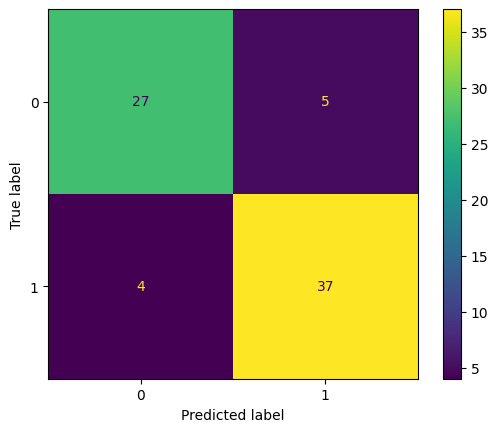

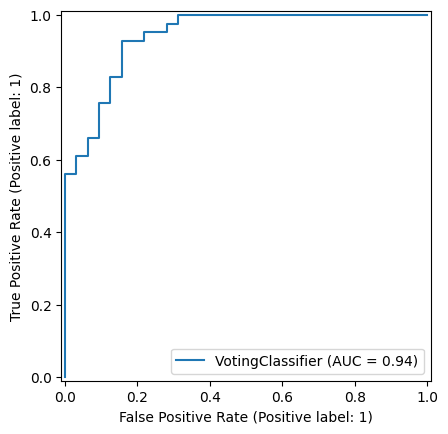

In [51]:
ConfusionMatrixDisplay.from_estimator(clf, x_test, y_test);
RocCurveDisplay.from_estimator(clf, x_test, y_test);

Distribution of predicted probabilty for each class

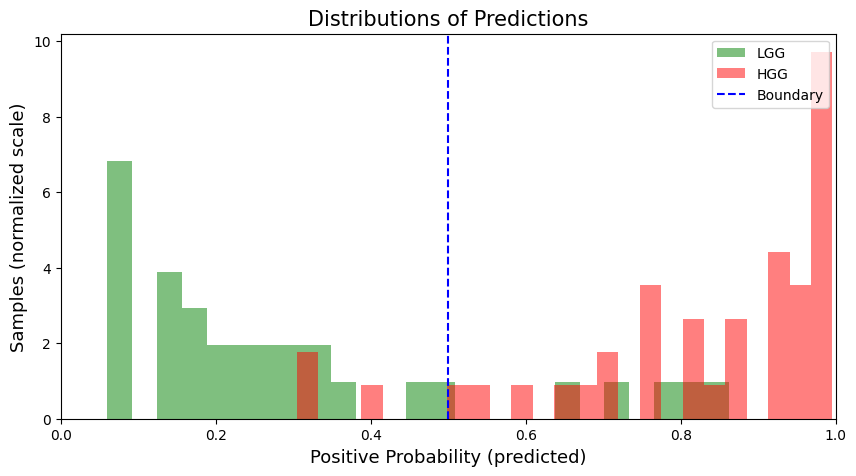

In [52]:
df = pd.DataFrame({'probPos': proba_test, 'target': y_test})
plt.figure(figsize=(10,5))
plt.hist(df[df.target == 0].probPos, density=True, bins=25,
             alpha=.5, color='green', label='LGG')
plt.hist(df[df.target == 1].probPos, density=True, bins=25,
             alpha=.5, color='red', label='HGG')
plt.axvline(.5, color='blue', linestyle='--', label='Boundary')
plt.xlim([0, 1])
plt.title('Distributions of Predictions', size=15)
plt.xlabel('Positive Probability (predicted)', size=13)
plt.ylabel('Samples (normalized scale)', size=13)
plt.legend(loc="upper right")
plt.show();